In [3]:
import torch
from transformers import AutoModelForCausalLM
import sys; sys.path.append('/dscilab_dungvo/workspace/vlm_clone/DeepSeek-VL2')

import datasets, huggingface_hub
disk_path ='/dscilab_dungvo/workspace/BA-PRE_THESIS/dataset_pretraining/SYNTH-PEDES/annotation_english_vietnamese_processed'
dataset = datasets.load_from_disk(disk_path)

from deepseek_vl2.models import DeepseekVLV2Processor, DeepseekVLV2ForCausalLM
from deepseek_vl2.utils.io import load_pil_images
from deepseek_vl2.serve.app_modules.utils import parse_ref_bbox 

In [4]:
load_pil_images??

Signature: load_pil_images(conversations: List[Dict[str, str]]) -> List[PIL.Image.Image]
Source:   
def load_pil_images(conversations: List[Dict[str, str]]) -> List[PIL.Image.Image]:
    """

    Args:
        conversations (List[Dict[str, str]]): the conversations with a list of messages. An example is :
            [
                {
                    "role": "User",
                    "content": "<image>\nExtract all information from this image and convert them into markdown format.",
                    "images": ["./examples/table_datasets.png"]
                },
                {"role": "Assistant", "content": ""},
            ]

    Returns:
        pil_images (List[PIL.Image.Image]): the list of PIL images.

    """

    pil_images = []

    for message in conversations:
        if "images" not in message:
            continue

        for image_path in message["images"]:
            pil_img = PIL.Image.open(image_path)
            pil_img = pil_img.convert("RGB")
        

In [ ]:
DeepseekVLV2Processor??

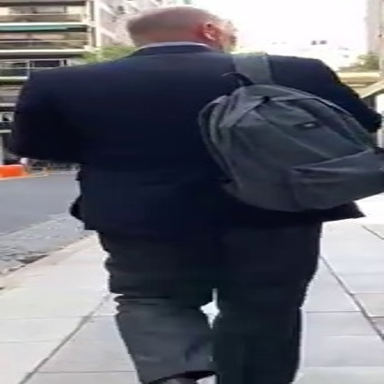

In [24]:
example_image =dataset[3000]['image'].resize((384, 384))
# save temp
example_image.save('example_image.jpg')
example_image

In [25]:
# model_path = "deepseek-ai/deepseek-vl2-tiny"
# vl_chat_processor: DeepseekVLV2Processor = DeepseekVLV2Processor.from_pretrained(
#     model_path
# )
# tokenizer = vl_chat_processor.tokenizer

# vl_gpt: DeepseekVLV2ForCausalLM = AutoModelForCausalLM.from_pretrained(
#     model_path, trust_remote_code=True, torch_dtype=torch.bfloat16, device_map='auto'
# )

In [ ]:

dtype = torch.bfloat16
chunk_size = 512
# specify the path to the model
model_path = "deepseek-ai/deepseek-vl2"
vl_chat_processor: DeepseekVLV2Processor = DeepseekVLV2Processor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: DeepseekVLV2ForCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    torch_dtype=dtype
)
vl_gpt = vl_gpt.cuda().eval()

# single image conversation example
# conversation = [
#     {
#         "role": "<|User|>",
#         "content": "<image>\n<image>\n<|grounding|>In the first image, an object within the red rectangle is marked. Locate the object of the same category in the second image.",
#         "images": [
#             "images/incontext_visual_grounding_1.jpeg",
#             "images/icl_vg_2.jpeg"
#         ],
#     },
#     {"role": "<|Assistant|>", "content": ""},
# ]

conversation = [
    {
        "role": "<|User|>",
        "content": "<image>\n<|ref|>The man.<|/ref|>.",
        "images": ["example_image.jpg"],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
print(f"len(pil_images) = {len(pil_images)}")

# input_ids = batched_input_ids,
# attention_mask = batched_attention_mask,
# labels = batched_labels,
# images_tiles = batched_images,
# images_seq_mask = batched_images_seq_mask,
# images_spatial_crop = batched_images_spatial_crop,
# sft_format = batched_sft_format,
# seq_lens = seq_lens

prepare_inputs = vl_chat_processor.__call__(
    conversations=conversation,
    images=pil_images,
    force_batchify=True,
    system_prompt=""
).to(vl_gpt.device, dtype=dtype)

# for key in prepare_inputs.keys():
#     value = prepare_inputs[key]
#     if isinstance(value, list):
#         print(key, len(value), type(value))
#     elif isinstance(value, torch.Tensor):
#         print(key, value.shape, type(value))

with torch.no_grad():

    if chunk_size == -1:
        inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
        past_key_values = None
    else:
        # incremental_prefilling when using 40G GPU for vl2-small
        inputs_embeds, past_key_values = vl_gpt.incremental_prefilling(
            input_ids=prepare_inputs.input_ids,
            images=prepare_inputs.images,
            images_seq_mask=prepare_inputs.images_seq_mask,
            images_spatial_crop=prepare_inputs.images_spatial_crop,
            attention_mask=prepare_inputs.attention_mask,
            chunk_size=chunk_size
        )

    # run the model to get the response
    outputs = vl_gpt.generate(
        # inputs_embeds=inputs_embeds[:, -1:],
        # input_ids=prepare_inputs.input_ids[:, -1:],
        inputs_embeds=inputs_embeds,
        input_ids=prepare_inputs.input_ids,
        images=prepare_inputs.images,
        images_seq_mask=prepare_inputs.images_seq_mask,
        images_spatial_crop=prepare_inputs.images_spatial_crop,
        attention_mask=prepare_inputs.attention_mask,
        past_key_values=past_key_values,

        pad_token_id=tokenizer.eos_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        max_new_tokens=512,

        # do_sample=False,
        # repetition_penalty=1.1,

        do_sample=True,
        temperature=0.4,
        top_p=0.9,
        repetition_penalty=1.1,

        use_cache=True,
    )

    answer = tokenizer.decode(outputs[0][len(prepare_inputs.input_ids[0]):].cpu().tolist(), skip_special_tokens=False)
    print(f"{prepare_inputs['sft_format'][0]}", answer)

    vg_image = parse_ref_bbox(answer, image=pil_images[-1])
    if vg_image is not None:
        vg_image.save("./vg.jpg", format="JPEG", quality=85)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: downsample_ratio, patch_size, image_mean, add_special_token, normalize, sft_format, pad_token, ignore_id, image_std, mask_prompt, image_token, candidate_resolutions. 


Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



In [2]:
import torch
from deepseek_vlv2_processor import DeepseekVLV2Processor
from transformers import AutoModelForCausalLM

dtype = torch.bfloat16
chunk_size = 512
model_path = "deepseek-ai/deepseek-vl2"

def load_model_and_processor(model_path, dtype):
    vl_chat_processor = DeepseekVLV2Processor.from_pretrained(model_path)
    tokenizer = vl_chat_processor.tokenizer
    vl_gpt = AutoModelForCausalLM.from_pretrained(
        model_path,
        trust_remote_code=True,
        torch_dtype=dtype
    ).cuda().eval()
    return vl_chat_processor, tokenizer, vl_gpt

def prepare_conversation(user_role, user_content, user_images, assistant_role, assistant_content):
    return [
        {
            "role": user_role,
            "content": user_content,
            "images": user_images,
        },
        {
            "role": assistant_role,
            "content": assistant_content,
        },
    ]

def load_and_prepare_images(conversation):
    pil_images = load_pil_images(conversation)
    print(f"len(pil_images) = {len(pil_images)}")
    return pil_images

def prepare_inputs(vl_chat_processor, conversation, pil_images, vl_gpt, dtype):
    return vl_chat_processor.__call__(
        conversations=conversation,
        images=pil_images,
        force_batchify=True,
        system_prompt=""
    ).to(vl_gpt.device, dtype=dtype)

def generate_response(vl_gpt, prepare_inputs, tokenizer, chunk_size):
    with torch.no_grad():
        if chunk_size == -1:
            inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
            past_key_values = None
        else:
            inputs_embeds, past_key_values = vl_gpt.incremental_prefilling(
                input_ids=prepare_inputs.input_ids,
                images=prepare_inputs.images,
                images_seq_mask=prepare_inputs.images_seq_mask,
                images_spatial_crop=prepare_inputs.images_spatial_crop,
                attention_mask=prepare_inputs.attention_mask,
                chunk_size=chunk_size
            )

        outputs = vl_gpt.generate(
            inputs_embeds=inputs_embeds,
            input_ids=prepare_inputs.input_ids,
            images=prepare_inputs.images,
            images_seq_mask=prepare_inputs.images_seq_mask,
            images_spatial_crop=prepare_inputs.images_spatial_crop,
            attention_mask=prepare_inputs.attention_mask,
            past_key_values=past_key_values,
            pad_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=512,
            do_sample=True,
            temperature=0.4,
            top_p=0.9,
            repetition_penalty=1.1,
            use_cache=True,
        )

        answer = tokenizer.decode(outputs[0][len(prepare_inputs.input_ids[0]):].cpu().tolist(), skip_special_tokens=False)
        print(f"{prepare_inputs['sft_format'][0]}", answer)
        return answer

def save_result(answer, pil_images):
    vg_image = parse_ref_bbox(answer, image=pil_images[-1])
    if vg_image is not None:
        vg_image.save("./vg.jpg", format="JPEG", quality=85)

# Main execution
vl_chat_processor, tokenizer, vl_gpt = load_model_and_processor(model_path, dtype)
conversation = prepare_conversation(
    user_role="<|User|>",
    user_content="<image>\n<|ref|>The man.<|/ref|>.",
    user_images=["example_image.jpg"],
    assistant_role="<|Assistant|>",
    assistant_content=""
)
pil_images = load_and_prepare_images(conversation)
prepare_inputs = prepare_inputs(vl_chat_processor, conversation, pil_images, vl_gpt, dtype)
answer = generate_response(vl_gpt, prepare_inputs, tokenizer, chunk_size)
save_result(answer, pil_images)

ModuleNotFoundError: No module named 'deepseek_vlv2_processor'

In [31]:
prepare_inputs.images.shape

torch.Size([1, 2, 3, 384, 384])

In [29]:
pil_images[0].size

(384, 384)

In [ ]:
vl_chat_processor

In [10]:
answer

'<|ref|>The backpage.<|/ref|><|det|>[[21, 13, 989, 987]]<|/det|><｜end▁of▁sentence｜>'

In [11]:
parse_ref_bbox(answer, image=pil_images[-1])

In [14]:
vg_image = parse_ref_bbox(answer, image=pil_images[-1])
if vg_image is not None:
    vg_image.save("./vg.jpg", format="JPEG", quality=85)

In [27]:
answer

'<|ref|>The backpage.<|/ref|><|det|>[[24, 10, 995, 987]]<|/det|><｜end▁of▁sentence｜>'

In [16]:
parse_ref_bbox

<function deepseek_vl2.serve.app_modules.utils.parse_ref_bbox(response, image: 'Image.Image')>

In [ ]:
vg_image

In [19]:
pil_images[0].size

(168, 410)

In [ ]:
## single image conversation example
image = dataset[0]['image']
conversation = [
    {
        "role": "<|User|>",
        "content": "<image>\n<|ref|>The giraffe at the back.<|/ref|>.",
        "images": [image],
    },
    {"role": "<|Assistant|>", "content": ""},
]


# conversation = [
#     {
#         "role": "<|User|>",
#         "content": "<image>\n<|ref|>The giraffe at the back.<|/ref|>.",
#         "images": ["./images/visual_grounding_1.jpeg"],
#     },
#     {"role": "<|Assistant|>", "content": ""},
# ]
# load images and prepare for inputs
# pil_images = load_pil_images(conversation)
pil_images = [image]
prepare_inputs = vl_chat_processor(
    conversations=conversation,
    images=pil_images,
    force_batchify=True,
    system_prompt=""
).to(vl_gpt.device)

# run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# run the model to get the response
outputs = vl_gpt.language.generate(
    input_ids= prepare_inputs["input_ids"],
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=False)
print(f"{prepare_inputs['sft_format'][0]}", answer)

In [62]:
prepare_inputs.attention_mask.shape

torch.Size([1, 438])

In [61]:
inputs_embeds.shape

torch.Size([1, 438, 1280])

In [60]:
def get_conversation(reference, image_path):
    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image>\n<|ref|>{reference}<|/ref|>.",
            "images": [image_path],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    return conversation


def prepare_model_inputs(conversation, vl_chat_processor, vl_gpt):
    pil_images = load_pil_images(conversation)
    model_inputs = vl_chat_processor(
        conversations=conversation,
        images=pil_images,
        force_batchify=True,
        system_prompt="",
    ).to(vl_gpt.device)
    return model_inputs

import torch
def get_answer(prepare_inputs, vl_gpt, tokenizer):
    with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
        inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)
        outputs = vl_gpt.language.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=prepare_inputs.attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            max_new_tokens=512,
            do_sample=True,
            use_cache=True,
        )
        answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=False)
    return answer


def get_answer_from_reference(
    reference, image_path, vl_chat_processor, vl_gpt, tokenizer
):
    conversation = get_conversation(reference, image_path)
    prepare_inputs = prepare_model_inputs(conversation, vl_chat_processor, vl_gpt)
    answer = get_answer(prepare_inputs, vl_gpt, tokenizer)
    return answer

import uuid, os, sys
def convert_pil_to_temp_file(pil_image):
    temp_file = f"/tmp/{uuid.uuid4()}.jpg"
    pil_image.save(temp_file)
    return temp_file


[{'role': '<|User|>',
  'content': '<image>\n<|ref|>black micro<|/ref|>.',
  'images': ['/tmp/18443f2e-a0a2-4fc1-abf6-96aacbbb363e.jpg']},
 {'role': '<|Assistant|>', 'content': ''}]

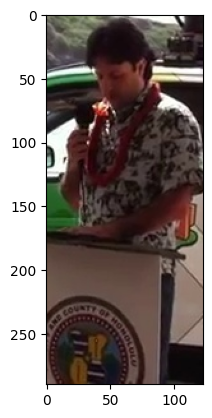

In [55]:
import matplotlib.pyplot as plt
image = dataset[100]['image']
plt.imshow(image)
image = convert_pil_to_temp_file(image)


reference = "black micro"
conversation = get_conversation(reference, image)
conversation


In [ ]:
get_answer_from_reference(
    "The black micro", image, vl_chat_processor, vl_gpt, tokenizer
)

In [ ]:
model_path = "deepseek-ai/deepseek-vl2-small"
vl_chat_processor: DeepseekVLV2Processor = DeepseekVLV2Processor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: DeepseekVLV2ForCausalLM = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)

Some kwargs in processor config are unused and will not have any effect: ignore_id, pad_token, image_token, image_mean, image_std, normalize, downsample_ratio, candidate_resolutions, patch_size, sft_format, add_special_token, mask_prompt. 


Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:100002
Add image token = ['<image>'] to the tokenizer
<image>:100003
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:100004
<|/ref|>:100005
<|det|>:100006
<|/det|>:100007
<|grounding|>:100008
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:100009
<|Assistant|>:100010



model-00003-of-000004.safetensors:   0%|          | 0.00/8.59G [00:00<?, ?B/s]

model-00004-of-000004.safetensors:   0%|          | 0.00/6.52G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
model_path = "deepseek-ai/deepseek-vl2"
vl_chat_processor: DeepseekVLV2Processor = DeepseekVLV2Processor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: DeepseekVLV2ForCausalLM = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: downsample_ratio, mask_prompt, pad_token, image_std, normalize, candidate_resolutions, image_token, sft_format, add_special_token, image_mean, patch_size, ignore_id. 


Add pad token = ['<｜▁pad▁｜>'] to the tokenizer
<｜▁pad▁｜>:2
Add image token = ['<image>'] to the tokenizer
<image>:128815
Add grounding-related tokens = ['<|ref|>', '<|/ref|>', '<|det|>', '<|/det|>', '<|grounding|>'] to the tokenizer with input_ids
<|ref|>:128816
<|/ref|>:128817
<|det|>:128818
<|/det|>:128819
<|grounding|>:128820
Add chat tokens = ['<|User|>', '<|Assistant|>'] to the tokenizer with input_ids
<|User|>:128821
<|Assistant|>:128822



Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]